<a href="https://colab.research.google.com/github/mowne67/Portfolio-Mowne/blob/main/Transfer_Learning_NLP_TF_Hub_w_o_TensorBoard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align=left> Transfer Learning for NLP with TensorFlow Hub</h2>

---

### Overview

[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

In this project, pre-trained models from TensorFlow Hub with [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) for text classification are used. Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset. In this project, we will demonstrate this by training with several different TF-Hub modules.

## Dataset

[Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data)

### Gist of the Objectives


- Used various pre-trained NLP text embedding models from TensorFlow Hub
- Performed transfer learning to fine-tune models on Quora Insincere Questions Dataset
- Visualized model performance metrics with [TensorBoard](https://www.tensorflow.org/tensorboard)

### Contents

This project/notebook consists of several Tasks.

- Introduction to the Project.
- Downloading and Importing the Quora Insincere Questions Dataset
- TensorFlow Hub for Natural Language Processing
- Defined Function to Build and Compile Models
- Training Various Text Classification Models
- Comparison with Accuracy and Loss Curves
- Fine-tuning Models from TF Hub
- Visualization of Metrics with TensorBoard

In [ ]:
!nvidia-smi
#Opening this notebook with Colab is recommended for viewing Tensorboard

Thu Aug  5 15:52:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
Version:  2.5.0
Hub version:  0.12.0
GPU is available


## Importing Quora Insincere Questions Dataset

A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). It is decompressed and read the data into a pandas DataFrame.

In [ ]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', compression = 'zip', low_memory = False)

In [ ]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


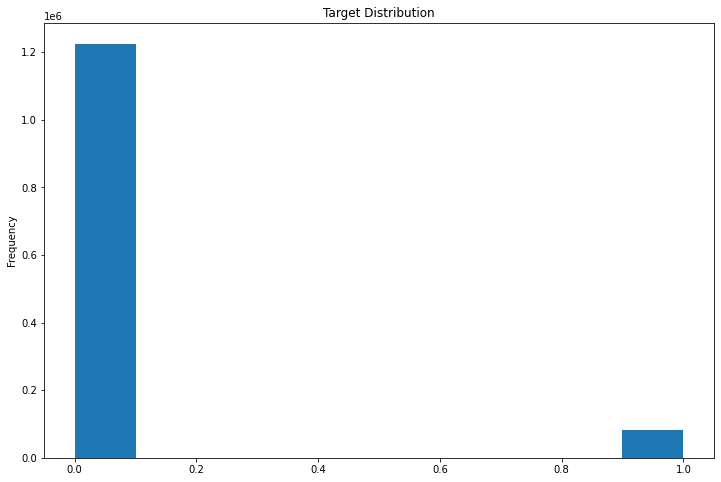

In [ ]:
df['target'].plot(kind='hist',title='Target Distribution')

As there is a class imbalace in the Target variable, we stratify the varibale across the training and validation dataset while splitting.

In [ ]:
from sklearn.model_selection import train_test_split
train_df, remaining = train_test_split(df, random_state = 42, train_size = 0.01, stratify = df.target.values)

In [ ]:
valid_df, _ = train_test_split(remaining,random_state = 42, train_size = 0.001, stratify = remaining.target.values)
#train_size here corresponds to the valid_df size

In [ ]:
train_df.target.head(20).values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
train_df.question_text.head(20).values

array(['What is your experience living in Venezuela in the current crisis? (2018)',
       'In which state/city the price of property is highest?',
       'Do rich blacks also call poor whites, “White Trash”?',
       'Should my 5 yr old son and 2 yr old daughter spend the summer with their father, after a domestic violent relationship?',
       'Why do we have parents?',
       'Do we experience ghost like Murphy did in Interstellar?',
       'Are Estoniano women beautiful?',
       'There was a Funny or Die video called Sensitivity Hoedown that got pulled. Does anyone know why?',
       'Is it a good idea to go in fully mainstream classes, even if I have meltdowns that might disrupt people?',
       'What classifies a third world country as such?',
       'Is being a pilot safe?',
       'Who is Illiteratendra Modi? Why does he keep with him a Rs 1 lakh pen?',
       'Have modern management strategies such as Total supply Chain Management applied to education? Can they be?',
       '

## TensorFlow Hub for Natural Language Processing

Our text data consits of questions and corresponding labels.

The question vector captures the semantics of the question and, as a result, can be effectively used for classification. 

To obtain question vectors, we have two alternatives that have been used for several text classification problems in NLP: 
* word-based representations and 
* context-based representations

#### Word-based Representations

- A **word-based representation** of a question combines word embeddings of the content words in the question. We can use the average of the word embeddings of content words in the question. Average of word embeddings have been used for different NLP tasks.
- Examples of pre-trained embeddings include:
  - **Word2Vec**: These are pre-trained embeddings of words learned from a large text corpora. Word2Vec has been pre-trained on a corpus of news articles with  300 million tokens, resulting in 300-dimensional vectors.
  - **GloVe**: has been pre-trained on a corpus of tweets with 27 billion tokens, resulting in 200-dimensional vectors.


#### Context-based Representations

- **Context-based representations** may use language models to generate vectors of sentences. So, instead of learning vectors for individual words in the sentence, they compute a vector for sentences on the whole, by taking into account the order of words and the set of co-occurring words.
- Examples of deep contextualised vectors include:
  - **Embeddings from Language Models (ELMo)**: uses character-based word representations and bidirectional LSTMs. The pre-trained model computes a contextualised vector of 1024 dimensions. ELMo is available on Tensorflow Hub.
  - **Universal Sentence Encoder (USE)**: The encoder uses a Transformer  architecture that uses attention mechanism to incorporate information about the order and the collection of words. The pre-trained model of USE that returns a vector of 512 dimensions is also available on Tensorflow Hub.
  - **Neural-Net Language Model (NNLM)**: The model simultaneously learns representations of words and probability functions for word sequences, allowing it to capture semantics of a sentence. We will use a  pretrained  models available on Tensorflow Hub, that are trained on the English Google News 200B corpus, and computes a vector of 128 dimensions for the larger model and 50 dimensions for the smaller model.


Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset. In this project, we will demonstrate this by training with several different TF-Hub modules.

These are the modules that are going to be implemented in this project:

In [ ]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

## Defining Function to Build and Compile Models

A Tensorflow Hub layer is created as a base and more Dense layers are added with the help of Keras. As this is a binary classification problem, we resort to Binary-cross-entropy as our loss function.

In [ ]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
  hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape = [embed_size], dtype = tf.string, trainable = trainable)
  model = tf.keras.models.Sequential([
                                      hub_layer,
                                      tf.keras.layers.Dense(256, activation= 'relu'),
                                      tf.keras.layers.Dense(64, activation = 'relu'),
                                      tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001), 
                loss = tf.losses.BinaryCrossentropy(),
                metrics = [tf.metrics.BinaryAccuracy(name = 'accuracy')])
  model.summary()
  history = model.fit(train_df['question_text'], train_df['target'],
                      epochs = 100,
                      batch_size = 32,
                      validation_data = (valid_df['question_text'], valid_df['target']),
                      callbacks = [tfdocs.modeling.EpochDots(),
                                   tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, mode = 'min'),
                                   tf.keras.callbacks.TensorBoard(logdir/name)],
                      verbose = 0
                      )
  return history
  

## Training Various Text Classification Models

In [ ]:
histories = {}

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [ ]:
histories["universal-sentence-encoder-large"] = train_and_evaluate_model(module_url, embed_size= 512, name = 'universal-sentence-encoder-large')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 512)               147354880 
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 147,502,721
Trainable params: 147,841
Non-trainable params: 147,354,880
_________________________________________________________________



Epoch: 0, accuracy:0.9240,  loss:0.3285,  val_accuracy:0.9381,  val_loss:0.1769,  
.............

## Fine-tuning Model from TF Hub

In [ ]:
histories["gnews-swivel-20dim-finetuned"] = train_and_evaluate_model(module_url, embed_size= 20, name = 'gnews-swivel-20dim-finetuned',
                                                                     trainable=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               5376      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 421,909
Trainable params: 421,909
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.9303,  loss:0.2693,  val_accuracy:0.9381,  val_loss:0.2022,  
..........

## All pre-tmodules that are being implemented:

In [ ]:
histories

{'gnews-swivel-20dim': <tensorflow.python.keras.callbacks.History at 0x7fafa409f4d0>,
 'gnews-swivel-20dim-finetuned': <tensorflow.python.keras.callbacks.History at 0x7faf923c0ed0>,
 'nnlm-en-dim128': <tensorflow.python.keras.callbacks.History at 0x7faf925f4bd0>,
 'nnlm-en-dim50': <tensorflow.python.keras.callbacks.History at 0x7fafa20aef10>,
 'universal-sentence-encoder': <tensorflow.python.keras.callbacks.History at 0x7faf8e2eff90>,
 'universal-sentence-encoder-large': <tensorflow.python.keras.callbacks.History at 0x7faee5c795d0>}

## Comparison with Accuracy and Loss Curves

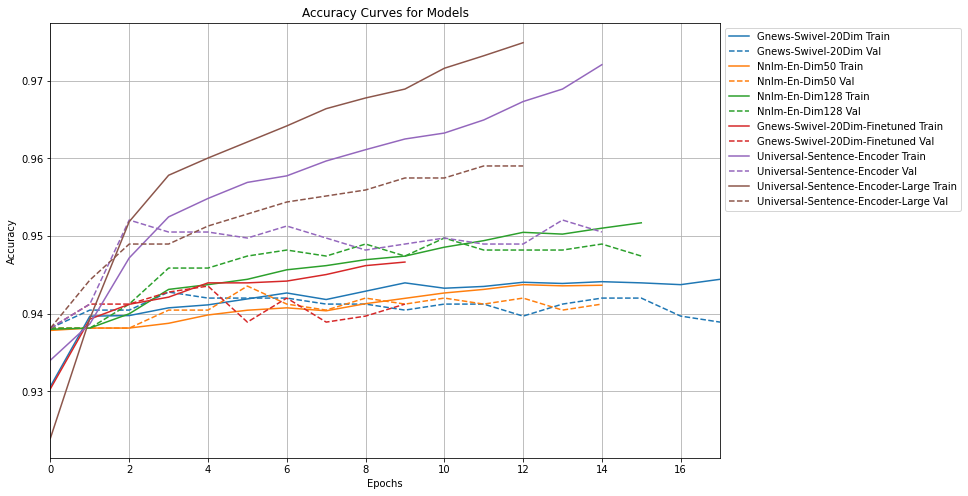

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

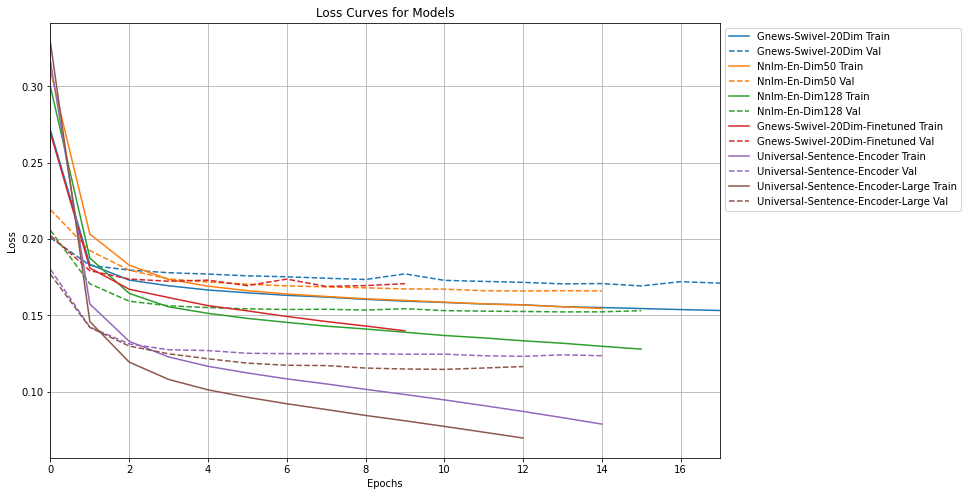

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

## Visualizing Metrics with TensorBoard

In [ ]:
%load_ext tensorboard

%tensorboard --logdir {logdir}
#Please Open With Colab to see Tensorboard